In [1]:
import pandas as pd
from sqlalchemy import create_engine, text

# Connection setup
engine = create_engine(
    "oracle+oracledb://",
    connect_args={
        "user": "raw_layer",
        "password": "Raw#123",
        "dsn": "localhost:1521/XEPDB1",
    },
    pool_pre_ping=True,
)

with engine.begin() as conn:
    # ✅ Query all tables visible to the current user
    query = text("""
        SELECT table_name
        FROM user_tables
        ORDER BY table_name
    """)
    tables = pd.read_sql(query, conn)
    print("📋 Tables found:")
    print(tables)

📋 Tables found:
       table_name
0        BRANCHES
1            CARS
2  CAR_CATEGORIES
3       CUSTOMERS
4      IOT_ALERTS
5     IOT_DEVICES
6   IOT_TELEMETRY
7        MANAGERS
8        PAYMENTS
9         RENTALS


In [2]:
IOT_TELEMETRY  = pd.read_sql("SELECT * FROM IOT_TELEMETRY", engine)
IOT_TELEMETRY.head()

,telemetry_id,device_id,car_id,rental_id,timestamp,latitude,longitude,speed_kmh,acceleration_ms2,brake_pressure_bar,fuel_level_pct,battery_voltage,engine_temp_c,odometer_km,event_type,created_at
0,84,591,626,141,2025-10-26 22:18:30,33.790318,-7.630736,23.97,0.076,0.00,95.77,14.47,108.87,12045,RAPID_ACCEL,2025-10-26 21:36:54
1,85,591,626,141,2025-10-26 22:19:00,33.790982,-7.632775,24.25,0.003,2.06,96.09,14.09,102.39,12045,DRIVING,2025-10-26 21:36:54
2,86,591,626,141,2025-10-26 22:19:30,33.791502,-7.634527,20.59,-0.034,1.94,97.20,13.96,93.66,12046,DRIVING,2025-10-26 21:36:54
3,87,591,626,141,2025-10-26 22:20:00,33.791550,-7.636533,22.21,0.015,0.78,97.02,13.76,95.32,12046,DRIVING,2025-10-26 21:36:54
4,88,591,626,141,2025-10-26 22:20:30,33.791341,-7.638290,19.65,-0.024,3.04,97.59,13.59,104.22,12047,DRIVING,2025-10-26 21:36:54


In [8]:
from geopy.distance import geodesic

# Loop through all rentals
for rid in sorted(IOT_TELEMETRY['rental_id'].unique()):
    rental_data = IOT_TELEMETRY[IOT_TELEMETRY['rental_id'] == rid].sort_values('timestamp')
    if rental_data.empty:
        continue

    # Extract start and end points
    first_lat, first_lon = rental_data.iloc[0][['latitude', 'longitude']]
    last_lat, last_lon = rental_data.iloc[-1][['latitude', 'longitude']]
    last_date = rental_data.iloc[-1]['timestamp']

    # Compute distance between start and end
    dist_km = geodesic((first_lat, first_lon), (last_lat, last_lon)).km

    # Print results
    print(f"📍 Rental ID: {rid}")
    print(f"  Start Location → Latitude: {first_lat:.6f}, Longitude: {first_lon:.6f}")
    print(f"  End Location   → Latitude: {last_lat:.6f}, Longitude: {last_lon:.6f}")
    print(f"  ➜ Distance between start and end: {dist_km:.2f} km")
    if dist_km > 1:
        print("  ⚠️  Potential anomaly (different start & end locations)")
    print("-" * 70)

📍 Rental ID: 141
  Start Location → Latitude: 33.573100, Longitude: -7.589800
  End Location   → Latitude: 33.972321, Longitude: -8.612946
  ➜ Distance between start and end: 104.61 km
  ⚠️  Potential anomaly (different start & end locations)
----------------------------------------------------------------------
📍 Rental ID: 142
  Start Location → Latitude: 34.020900, Longitude: -6.841600
  End Location   → Latitude: 33.687142, Longitude: -6.355580
  ➜ Distance between start and end: 58.25 km
  ⚠️  Potential anomaly (different start & end locations)
----------------------------------------------------------------------
📍 Rental ID: 143
  Start Location → Latitude: 31.629500, Longitude: -7.981100
  End Location   → Latitude: 32.949530, Longitude: -7.138667
  ➜ Distance between start and end: 166.50 km
  ⚠️  Potential anomaly (different start & end locations)
----------------------------------------------------------------------
📍 Rental ID: 144
  Start Location → Latitude: 35.759500, Lo

###  Interpretation

That means the synthetic trip didn’t return to its origin, so this rental looks more like a one-way trip than a round-trip.  
If your data-generation logic assumes cars should start and end near the same branch, then this record (rental_id = 141) should be flagged as inconsistent or needs correction.

The distance between the start and the end localisation should pass > 1km.

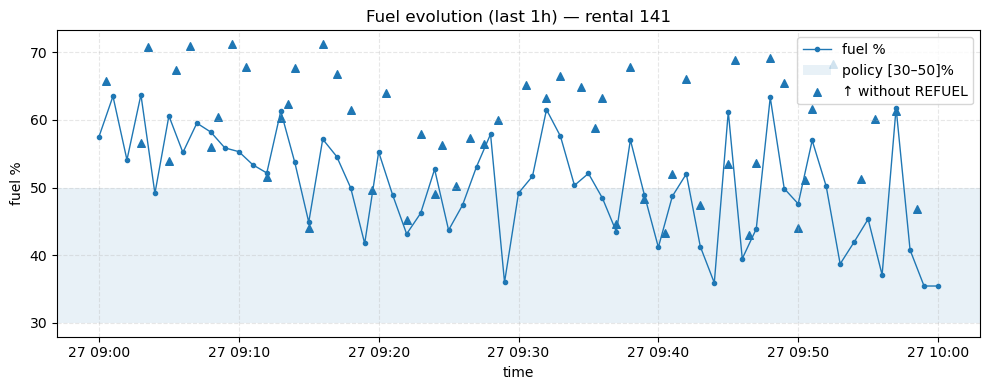

In [18]:
import pandas as pd, matplotlib.pyplot as plt

df = IOT_TELEMETRY.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['rental_id','timestamp'])

def plot_rental_window(rid, hours=3):
    t = df[df.rental_id==rid].copy().sort_values('timestamp')

    end   = t['timestamp'].max()
    start = end - pd.Timedelta(hours=hours)
    t = t[(t['timestamp']>=start) & (t['timestamp']<=end)].copy()
    if t.empty: 
        print(f'no data for last {hours}h, rental {rid}'); return

    # anomalies (ultra simple)
    t['d']  = t['fuel_level_pct'].astype(float).diff()
    t['dt'] = t['timestamp'].diff().dt.total_seconds()
    inc_wo_refuel = t[(t.d>2) & (~t.event_type.astype(str).str.upper().str.contains('REFUEL', na=False))]
    inst_drop     = t[(t.d<-0.5) & (t.dt<=10)]

    # (optionnel) lissage 1min du fuel pour lisibilité
    fuel_sm = (t.set_index('timestamp')['fuel_level_pct'].astype(float)
                 .resample('1min').median().ffill())

    plt.figure(figsize=(10,4))
    plt.plot(fuel_sm.index, fuel_sm.values, marker='.', linewidth=1, label='fuel %')
    plt.axhspan(30,50,alpha=.1,label='policy [30–50]%')
    if not inc_wo_refuel.empty:
        plt.scatter(inc_wo_refuel.timestamp, inc_wo_refuel.fuel_level_pct, s=30, marker='^', label='↑ without REFUEL')
    if not inst_drop.empty:
        plt.scatter(inst_drop.timestamp, inst_drop.fuel_level_pct, s=35, marker='x', label='instant drop (≤10s)')
    if not (30<=t.fuel_level_pct.iloc[0]<=50):
        plt.scatter([t.timestamp.iloc[0]],[t.fuel_level_pct.iloc[0]], s=60, marker='D', label='start ![30–50]%')

    plt.title(f'Fuel evolution (last {hours}h) — rental {rid}')
    plt.xlabel('time'); plt.ylabel('fuel %'); plt.grid(True, ls='--', alpha=.3); plt.legend(); plt.tight_layout(); plt.show()

# usage:
plot_rental_window(rid=141, hours=1)   # 3h window

### Fuel Level Generation Rules

- **Initial Fuel Level**: Fuel levels should not always start at 100%. Instead, they should begin at approximately 30%–50% to simulate realistic vehicle conditions.
- **Refueling Intervals**: Refueling should occur at regular intervals, with a minimum distance of 50 km and a maximum of 100 km between fills. This ensures natural consumption patterns.
- **Level Increases**: Do not increase the fuel level without a valid reason (e.g., no spontaneous refills outside of scheduled intervals).
- **Fuel Decrease**: The decrease in fuel level should not be too abrupt between consecutive readings (e.g., between the first and second timestamp). Limit drops to realistic rates based on vehicle efficiency and distance traveled.
- **Avoid Unrealistic Patterns**: Prevent sinusoidal oscillations in fuel levels (e.g., 50% → 60% → 50% → 60%), as these do not reflect real-world consumption. Ensure fuel levels decrease steadily based on usage, with increases only from explicit refueling events.

C:\Users\hamza\AppData\Local\Temp\ipykernel_32544\1935091999.py:29: UserWarning: Glyph 9981 (\N{FUEL PUMP}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
C:\Users\hamza\miniconda3\envs\cenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9981 (\N{FUEL PUMP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


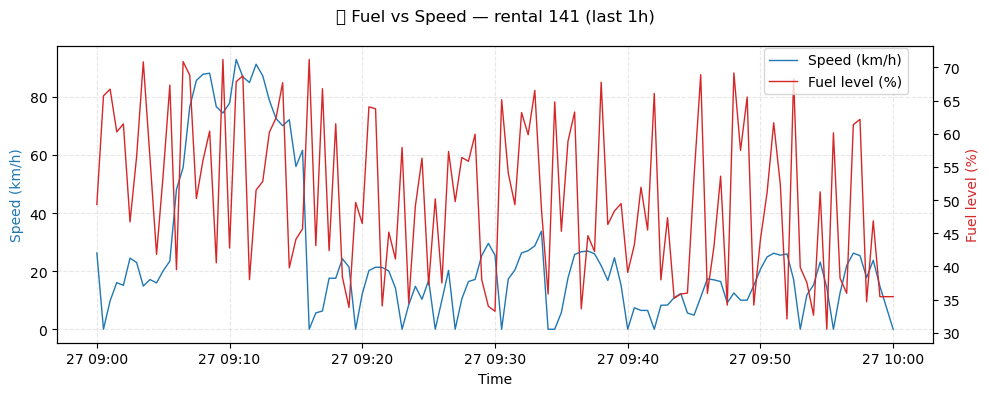

In [20]:
import pandas as pd, matplotlib.pyplot as plt

df = IOT_TELEMETRY.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['rental_id','timestamp'])

def plot_fuel_vs_speed(rid, hours=3):
    t = df[df.rental_id==rid].copy().sort_values('timestamp')

    end   = t['timestamp'].max()
    start = end - pd.Timedelta(hours=hours)
    t = t[(t['timestamp']>=start) & (t['timestamp']<=end)]
    if t.empty:
        print(f"No data in last {hours}h for rental {rid}")
        return

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax2 = ax1.twinx()

    ax1.plot(t.timestamp, t.speed_kmh, color='tab:blue', label='Speed (km/h)', linewidth=1)
    ax2.plot(t.timestamp, t.fuel_level_pct, color='tab:red', label='Fuel level (%)', linewidth=1)

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Speed (km/h)', color='tab:blue')
    ax2.set_ylabel('Fuel level (%)', color='tab:red')

    ax1.grid(True, linestyle='--', alpha=0.3)
    fig.suptitle(f'⛽ Fuel vs Speed — rental {rid} (last {hours}h)')
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(0.92, 0.9))
    plt.show()

# Example usage:
plot_fuel_vs_speed(141, hours=1)


- **Correlation with Vehicle Speed** : Assuming the base fuel level generation is functioning correctly, it must be combined with vehicle speed data to model realistic fuel consumption. Higher speeds should accelerate fuel depletion (e.g., via a consumption rate formula like consumption = base_rate * (speed / 100)^2), ensuring dynamic and physics-based realism.

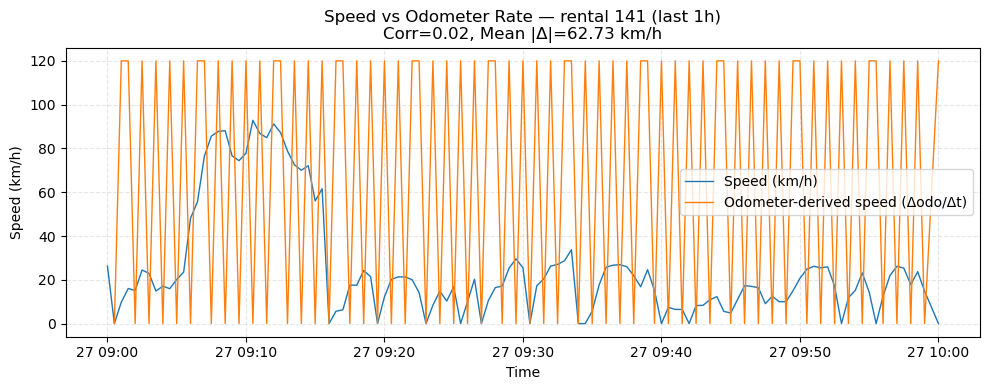

📊 Rental 141:
  ➜ Correlation between speed_kmh & odometer rate: 0.019
  ➜ Mean absolute difference: 62.73 km/h
  ⚠️  Inconsistent relationship — odometer and speed may not be combined properly.


In [23]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np

df = IOT_TELEMETRY.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['rental_id', 'timestamp'])

def analyze_speed_odometer(rid, hours=3):
    t = df[df.rental_id == rid].copy().sort_values('timestamp')

    end = t['timestamp'].max()
    start = end - pd.Timedelta(hours=hours)
    t = t[(t['timestamp'] >= start) & (t['timestamp'] <= end)]
    if t.empty:
        print(f"No data in last {hours}h for rental {rid}")
        return

    # Compute delta time (h) and odometer change (km)
    t['dt_h'] = t['timestamp'].diff().dt.total_seconds() / 3600
    t['d_odo'] = t['odometer_km'].diff()
    t['odo_rate_kmh'] = t['d_odo'] / t['dt_h']

    # Filter valid values
    t_valid = t[(t['odo_rate_kmh'].notna()) & (t['dt_h'] > 0)]

    # Compute correlation & mean difference
    corr = t_valid['speed_kmh'].corr(t_valid['odo_rate_kmh'])
    mean_diff = np.mean(np.abs(t_valid['speed_kmh'] - t_valid['odo_rate_kmh']))

    # Plot comparison
    plt.figure(figsize=(10,4))
    plt.plot(t.timestamp, t.speed_kmh, color='tab:blue', label='Speed (km/h)', linewidth=1)
    plt.plot(t.timestamp, t.odo_rate_kmh, color='tab:orange', label='Odometer-derived speed (Δodo/Δt)', linewidth=1)

    plt.title(f"Speed vs Odometer Rate — rental {rid} (last {hours}h)\n"
              f"Corr={corr:.2f}, Mean |Δ|={mean_diff:.2f} km/h")
    plt.xlabel("Time")
    plt.ylabel("Speed (km/h)")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Quick text summary
    print(f"📊 Rental {rid}:")
    print(f"  ➜ Correlation between speed_kmh & odometer rate: {corr:.3f}")
    print(f"  ➜ Mean absolute difference: {mean_diff:.2f} km/h")
    if corr < 0.8 or mean_diff > 10:
        print("  ⚠️  Inconsistent relationship — odometer and speed may not be combined properly.")
    else:
        print("  ✅  Odometer and speed seem well combined.\n")

# Example:
analyze_speed_odometer(141, hours=1)

### Speed Generation Rules

- **Idle Periods (Speed = 0)**: It is not realistic for vehicle speed to always be greater than 0. Incorporate idle times to simulate pauses, such as parking or overnight stops, where speed drops to 0 km/h.
- **Pause Frequency and Timing**: Users can and should have realistic pauses. Most pauses occur during common off-peak hours, such as:
  - 00:00–07:00 (overnight rest).
  - 14:00–16:00 (midday breaks, e.g., lunch or siesta).
  - Additional slots as needed (e.g., 20:00–22:00 for evenings), ensuring pauses align with daily human routines to avoid constant motion.